In [1]:
import json
import os
from os import listdir
from os.path import isfile, join
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tabulate
import numpy as np
import math

import re

from itertools import cycle, islice

# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 

from scipy.stats import normaltest
from scipy.stats import pearsonr
from scipy.stats import spearmanr
    
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    #'text.fontsize': 8, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [3]:
data_dir = join('..', 'data', 'dataset_data')
exp_log_dir = join('..', 'data', 'aggregated_data-incremental_exp_cikm')
out_dir = join('..', 'plots', 'statistical_analysis')


appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False


appname = 'BSBM'
data_size_dir = 'BSBM'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True

appname = 'dyldo_y2019_core'
data_size_dir = 'DyLDO-core'
collections =['schemex', 'attribute', 'type']
suffix = '-test-1_clean'
hide_legend = True

appname = 'dyldo_y2019_full'
data_size_dir = 'DyLDO-ext'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True

drop the beat


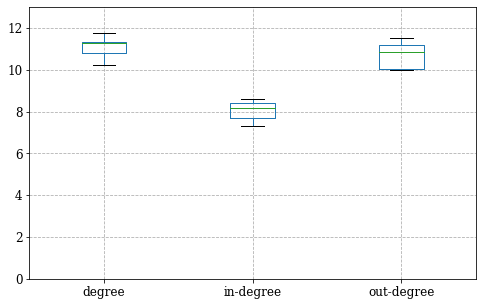

In [4]:
curr_dir = join(data_dir, data_size_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".csv")]
onlyfiles.sort(key=natural_keys)

degree_frame = pd.DataFrame()
i = 0
for filename in onlyfiles:
    with open(os.path.join(curr_dir, filename), 'r') as f:
        df = pd.read_csv(f, sep=',')
        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('degree.csv', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')
            i = int(iteration)
        else:
            i = i + 1

        df['Iteration'] = i
        df = df.set_index('Iteration')
        if degree_frame.empty:
            degree_frame = df
        else:
            degree_frame = degree_frame.append(df)

#plot = degree_frame['max_degree'].plot()  
if appname == 'dyldo_y2019_core':
    degree_frame = degree_frame.drop(degree_frame.index[[21,22]])


if appname == 'dyldo_y2019_full':
    degree_frame = degree_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')

    
#ax.set_ylabel("")

plot_frame = degree_frame[['avg_degree', 'avg_indegree', 'avg_outdegree']]

plot_frame.columns = ['degree', 'in-degree', 'out-degree']

fig, ax_new = plt.subplots(1,1, sharey=False)

boxplot = plot_frame.boxplot() 

ax_new.set_ylim(0, 13)

plt.savefig(out_dir + '/' + data_size_dir + '-degree.pdf', bbox_inches = 'tight')
plt.savefig(out_dir + '/' + data_size_dir + '-degree.png', bbox_inches = 'tight')

In [5]:
display(degree_frame['avg_degree'].mean())
display(degree_frame['avg_degree'].std())

display(degree_frame['avg_indegree'].mean())
display(degree_frame['avg_indegree'].std())

display(degree_frame['avg_outdegree'].mean())
display(degree_frame['avg_outdegree'].std())

11.07491532415266

0.5949726907531323

8.041314730068759

0.5472316030293805

10.71262458897485

0.6921430537578859

In [86]:
def scatter_plot_regression(df, x_value, y_value):

    # D'Agostino's K-squared test
    stat, p = normaltest(df[x_value])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('%s follows normal distribution' % x_value)
    else:
        print('%s does not follow normal distribution' % x_value)

    stat, p = normaltest(df[y_value])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('%s follows normal distribution' % y_value)
    else:
        print('%s does not follow normal distribution' % y_value)
        

    
    print("Is there a monotonic relationship between '%s' and '%s'?" % (x_value, y_value))
    corrtest = spearmanr(df[x_value], df[y_value])
    print("Spearman rank-order correlation coefficient of %.3f (p = %.6f)" % (round(corrtest[0], 3), round(corrtest[1], 6)))  
    
            
    print("Is there a linear correlation between '%s' and '%s'?" % (x_value, y_value))
    corrtest = pearsonr(df[x_value], df[y_value]) 
    print("Pearson Coefficient of %.3f (p = %.6f)" % (round(corrtest[0], 3), round(corrtest[1], 6)))    
    
    
    X = df[x_value].to_numpy() # , 'change-ratio'
    y = df[y_value].values
    #display(X)
    # make matrix
    X = X.reshape(-1, 1) 
    lin = LinearRegression() 

    print(X.shape)
    print(y.shape)
    lin.fit(X, y) 
    print("Linear Regression Coefficient of %.3f" % round(lin.coef_[0], 3))
    # Visualising the Linear Regression results 
    plt.scatter(X, y, color = 'blue') 
    #plt.scatter(b, y, color = 'green') 

    plt.plot(X, lin.predict(X), color = 'red') 
    plt.title('Linear Regression') 
    plt.xlabel(x_value) 
    plt.ylabel(y_value) 

    lin.score(X, y)
    plt.savefig(out_dir + '/' + x_value + '-vs-' + y_value + '.pdf', bbox_inches = 'tight')
    plt.savefig(out_dir + '/' + x_value + '-vs-' + y_value + '.png', bbox_inches = 'tight')
    plt.show() 

stat=9.045, p=0.011
edges does not follow normal distribution
stat=0.030, p=0.985
attributeschema-computation follows normal distribution
Is there a monotonic relationship between 'edges' and 'attributeschema-computation'?
Spearman rank-order correlation coefficient of 0.478 (p = 0.000587)
Is there a linear correlation between 'edges' and 'attributeschema-computation'?
Pearson Coefficient of 0.503 (p = 0.000272)
(48, 1)
(48,)
Linear Regression Coefficient of 0.002


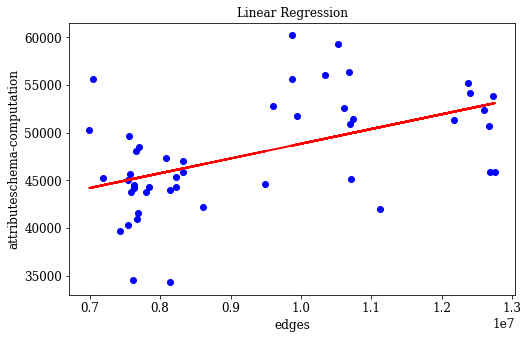

In [87]:
x_values = ['attribute:change-size-ratio'] #'change-ratio'
x_values = ['attribute:update-size-ratio'] #'change-ratio'
x_values = ['edges']


y_value = ['attributespeed-up']
y_value = ['attributeschema-computation']

x_value = 'edges'
y_value = 'attributeschema-computation'
scatter_plot_regression(size_frame, x_value, y_value)



In [92]:
# The main correlation analysis

appnames = ['LUBM', 'BSBM', 'dyldo_y2019_core', 'dyldo_y2019_full']
#appnames = ['dyldo_y2019_core']

datasets = ['LUBM', 'BSBM', 'DyLDO-core', 'DyLDO-ext']
#datasets = ['DyLDO-core']

models = ['schemex', 'attribute', 'type']
#models = ['attribute']


size_frame = pd.DataFrame(columns=['dataset', 'edges', 'types', 'bytes'])

index = 0
for dataset in datasets:
    curr_dir = join(data_dir, dataset)
    onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
    onlyfiles.sort(key=natural_keys)


    temp_frame = pd.DataFrame(columns=['dataset', 'edges', 'types', 'bytes', 'degree'])
    i = 0
    for filename in onlyfiles:
        f = open(join(curr_dir,filename), 'r')
        f_degree = open(join(curr_dir,filename.replace(".txt", "-degree.csv")), 'r')
        content = f.read().split('\n')

        df = pd.read_csv(f_degree, sep=',')
        df['Iteration'] = i
        df = df.set_index('Iteration')

        types = int(content[0])
        edges = int(content[1])
        bytez = int(content[2])
        degree = df['avg_degree'].values[0]

        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('.txt', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')
            i = int(iteration)
        else:
            i = i + 1
        temp_frame.loc[i] = [dataset, edges, types, bytez, degree]
        

    
    for model in models:
        f_space = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-update-time-and-space.csv'), 'r')
        #print(f_space)
        sf = pd.read_csv(f_space, sep=',')
        sf = sf.set_index('Iteration')
        #display(sf)
        temp_frame[model+'-summarization-ratio'] = sf['Imprint links'] / sf['Schema Elements (SE)']
        temp_frame[model+'VHI'] = sf['Sec. Index Size (bytes)']
        temp_frame[model+'-compression'] = temp_frame[model+'VHI'] / temp_frame['bytes']
        if 'instances' not in temp_frame:
            temp_frame['instances'] = sf['Imprint links']
        f_time = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-performance.csv'), 'r')
        #print(f_time)
        tf = pd.read_csv(f_time, sep=',')
        tf = tf.set_index('Iteration')
        #display(tf)
        temp_frame[model+'schema-computation'] = tf['Schema Computation']
        temp_frame[model+'update'] = tf['Updates']
        temp_frame[model+'incremental'] = tf['Total']
        temp_frame[model+'batch'] = tf['Batch']
        temp_frame[model+'speed-up'] = tf['Batch'] / tf['Total']

        
        f_change = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-changes.csv'), 'r')
        cf = pd.read_csv(f_change, sep=',')
        temp_frame[model+':changes'] = cf['ChangedSchemaStructures (SE_mod)'] +  ((sf['Imprint links'] - sf['Imprint links'].shift(1,fill_value=0)).abs())
        temp_frame[model+':updates'] = cf['NewlyObservedSchema (SE_new)'] + cf['DeletedSchemaStructures (SE_del)']
        temp_frame[model+':change-update-ratio'] = temp_frame[model+':changes']/(temp_frame[model+':updates'] + 1)
        #attribute:changes
        temp_frame[model+':change-size-ratio'] = temp_frame[model+':changes']/(temp_frame['instances'])
        temp_frame[model+':update-size-ratio'] = temp_frame[model+':updates']/(sf['Schema Elements (SE)'])

    if dataset == 'DyLDO-core':
        temp_frame = temp_frame.drop(temp_frame.index[[20,21]])
    if dataset == 'DyLDO-ext':
        temp_frame = temp_frame.head(5)
        
    if size_frame.empty:
        size_frame = temp_frame
    else:
        size_frame = size_frame.append(temp_frame)
        
  
    index = index + 1
#speedup for last row does not make sense
size_frame.dropna(inplace=True)

size_frame.to_csv(out_dir + '/' + 'correlation-stats.csv', sep=',', encoding='utf-8')

display(size_frame)
for model in models:
    print("Summarization Ratio ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'-summarization-ratio'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'-summarization-ratio'].std()))
    print("\tMin:\t {}".format(size_frame[model+'-summarization-ratio'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'-summarization-ratio'].max()))

    print("Change-Update Ratio ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+':change-update-ratio'].mean()))
    print("\tStd:\t {}".format(size_frame[model+':change-update-ratio'].std()))
    print("\tMin:\t {}".format(size_frame[model+':change-update-ratio'].min()))
    print("\tMAX:\t {}".format(size_frame[model+':change-update-ratio'].max()))
    
    print("Incremental Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'incremental'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'incremental'].std()))
    print("\tMin:\t {}".format(size_frame[model+'incremental'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'incremental'].max()))
    
    print("Batch Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'batch'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'batch'].std()))
    print("\tMin:\t {}".format(size_frame[model+'batch'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'batch'].max()))
    
    print("Speed-up Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'speed-up'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'speed-up'].std()))
    print("\tMin:\t {}".format(size_frame[model+'speed-up'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'speed-up'].max()))
    print("-----------")

    
#display(size_frame)
print('schemex')
display(size_frame['attribute-compression'])
print(size_frame['schemex-compression'].mean())
print(size_frame['schemex-compression'].std())

print('attribute')
print(size_frame['attribute-compression'].mean())
print(size_frame['attribute-compression'].std())

print('type')
print(size_frame['type-compression'].mean())
print(size_frame['type-compression'].std())

,dataset,edges,types,bytes,degree,schemex-summarization-ratio,schemexVHI,schemex-compression,instances,schemexschema-computation,...,typeschema-computation,typeupdate,typeincremental,typebatch,typespeed-up,type:changes,type:updates,type:change-update-ratio,type:change-size-ratio,type:update-size-ratio
0,LUBM,11096695,2308688,113341389,6.724367,6433.814925,45199685.0,0.398792,2155328.0,99282.0,...,91296.0,286483.0,1747804.0,1810321.0,1.035769,2155328.0,53.0,39913.481481,1.000000,1.000000
1,LUBM,10971370,2285287,112199571,6.722140,6370.911243,45620382.0,0.4066,2153368.0,103351.0,...,86738.0,283538.0,1728500.0,1798127.0,1.040282,133216.0,13.0,9515.428571,0.061864,0.250000
2,LUBM,10956090,2282653,112119291,6.720666,6372.832845,45787050.0,0.408378,2173136.0,99175.0,...,89074.0,301528.0,1762553.0,1798543.0,1.020419,162211.0,6.0,23173.000000,0.074644,0.111111
3,LUBM,11074551,2302963,113368625,6.723471,6239.345821,45492927.0,0.401283,2165053.0,106023.0,...,89766.0,299694.0,1754082.0,1797228.0,1.024597,139544.0,9.0,13954.400000,0.064453,0.163636
4,LUBM,11017277,2294578,112795019,6.720081,6357.523392,45407655.0,0.402568,2174273.0,99883.0,...,95995.0,291634.0,1749196.0,1841167.0,1.052579,136981.0,8.0,15220.111111,0.063001,0.150943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,DyLDO-core,7630285,0,132829033,3.424638,21.129701,82997851.5,0.624847,1594574.0,42883.0,...,43482.0,146385.0,945180.0,4920808.0,5.206213,23377.0,25.0,899.115385,0.014660,0.004348
1,DyLDO-ext,82221979,9190424,1310548703,11.293063,30.075982,275299698.0,0.210064,7509702.0,344435.0,...,323189.0,615491.0,9184283.0,55412381.0,6.033392,288916.0,11857.0,24.364648,0.038472,0.298027
2,DyLDO-ext,82245640,8165381,1179425120,10.208752,29.404855,277311609.0,0.235124,7064987.0,278444.0,...,306093.0,571810.0,9361245.0,56750178.0,6.062247,543112.0,19435.0,27.943610,0.076874,0.497211
3,DyLDO-ext,82381421,8872146,1303259364,11.311272,45.547427,392818513.0,0.301412,10592783.0,425795.0,...,432150.0,855957.0,13151973.0,94560702.0,7.189849,3660126.0,13963.0,262.111573,0.345530,0.439351


Summarization Ratio (schemex): 
	Mean:	 654.997861573418
	Std:	 1902.020352418429
	Min:	 18.387952127659574
	MAX:	 6624.530487804878
Change-Update Ratio (schemex): 
	Mean:	 901.5665089663158
	Std:	 1737.4032986587456
	Min:	 3.456093868281605
	MAX:	 7483.777777777777
Incremental Time (schemex): 
	Mean:	 2577792.4368932038
	Std:	 5699067.846854014
	Min:	 20373.0
	MAX:	 34317548.0
Batch Time (schemex): 
	Mean:	 4058247.9708737866
	Std:	 7254694.99152466
	Min:	 14895.0
	MAX:	 45877172.0
Speed-up Time (schemex): 
	Mean:	 1.8447280363693987
	Std:	 0.6946783641951172
	Min:	 0.3835358945308477
	MAX:	 2.9622230816076853
-----------
Summarization Ratio (attribute): 
	Mean:	 11470.326362634207
	Std:	 22759.15457529055
	Min:	 104.05656379548596
	MAX:	 83271.26923076923
Change-Update Ratio (attribute): 
	Mean:	 19720.714321315303
	Std:	 30157.14780284535
	Min:	 3.1671168129642133
	MAX:	 155093.5
Incremental Time (attribute): 
	Mean:	 2179190.213592233
	Std:	 4617459.784995109
	Min:	 14573.0
	MAX:	 

0     0.393504
1     0.397269
2     0.398932
3     0.391674
4     0.393573
        ...   
50    0.599312
1     0.204558
2     0.229488
3     0.295622
4     0.263966
Name: attribute-compression, Length: 103, dtype: object

0.37874301656608933
0.2726066053134856
attribute
0.3619367540574144
0.26574057438566057
type
0.3507873069059511
0.256004516091709


In [94]:
size_frame['dataset'].unique()

array(['LUBM', 'BSBM', 'DyLDO-core', 'DyLDO-ext'], dtype=object)

In [95]:
#tmp = size_frame[['edges', 'schemexschema-computation', 'attributeschema-computation', 'typeschema-computation']]
# display(tmp.head())
# display(tmp.astype('float64').corr())

"""
Build a frame for all three summary models:
"""

full_frame = pd.DataFrame(columns=['vertices', 'edges', 'vertexHashIndex', 'schema-computation'])
full_frame['vertices'] = size_frame['instances'].append(size_frame['instances']).append(size_frame['instances'])
full_frame['edges'] = size_frame['edges'].append(size_frame['edges']).append(size_frame['edges'])
full_frame['vertexHashIndex'] = size_frame['schemexVHI'].append(size_frame['attributeVHI']).append(size_frame['typeVHI'])
full_frame['schema-computation'] = size_frame['schemexschema-computation'].append(size_frame['attributeschema-computation']).append(size_frame['typeschema-computation'])
full_frame['schema-update'] = size_frame['schemexupdate'].append(size_frame['attributeupdate']).append(size_frame['typeupdate'])
full_frame['instance-changes'] = size_frame['schemex:changes'].append(size_frame['attribute:changes']).append(size_frame['type:changes'])


display(full_frame)


# print("Do edges correlate with vertexHashIndex?")
# corrtest = pearsonr(full_frame['edges'], full_frame['vertexHashIndex'])  
# display(corrtest)

# corrtest = pearsonr(size_frame['edges'], size_frame['typeschema-computation'])  
# display(corrtest)

display(full_frame['vertexHashIndex'].mean())

,vertices,edges,vertexHashIndex,schema-computation,schema-update,instance-changes
0,2155328.0,11096695,45199685.0,99282.0,445274.0,2155328.0
1,2153368.0,10971370,45620382.0,103351.0,460959.0,698251.0
2,2173136.0,10956090,45787050.0,99175.0,446380.0,777969.0
3,2165053.0,11074551,45492927.0,106023.0,437796.0,708085.0
4,2174273.0,11017277,45407655.0,99883.0,444164.0,688473.0
...,...,...,...,...,...,...
50,1594574.0,7630285,77340291.0,43482.0,146385.0,23377.0
1,7509702.0,82221979,251675361.0,323189.0,615491.0,288916.0
2,7064987.0,82245640,254293901.0,306093.0,571810.0,543112.0
3,10592783.0,82381421,355904489.0,432150.0,855957.0,3660126.0


64665644.04368932

In [75]:
from scipy import stats
print(stats.entropy(pk=full_frame['edges'].to_list(), qk=full_frame['schema-computation'].to_list()))

0.014266444538469264


In [80]:
stats.kstest(full_frame['vertices'].to_list(), 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

stat=315.348, p=0.000
edges does not follow normal distribution
stat=303.838, p=0.000
schema-computation does not follow normal distribution
Is there a monotonic relationship between 'edges' and 'schema-computation'?
Spearman rank-order correlation coefficient of 0.867 (p = 0.000000)
Is there a linear correlation between 'edges' and 'schema-computation'?
Pearson Coefficient of 0.943 (p = 0.000000)
(309, 1)
(309,)
Linear Regression Coefficient of 0.004


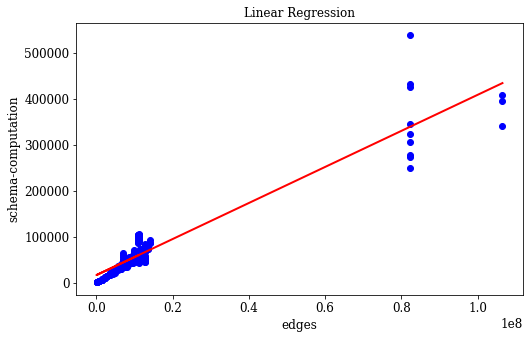

In [96]:
scatter_plot_regression(full_frame, 'edges', 'schema-computation')

stat=258.084, p=0.000
vertices does not follow normal distribution
stat=197.341, p=0.000
vertexHashIndex does not follow normal distribution
Is there a monotonic relationship between 'vertices' and 'vertexHashIndex'?
Spearman rank-order correlation coefficient of 0.908 (p = 0.000000)
Is there a linear correlation between 'vertices' and 'vertexHashIndex'?
Pearson Coefficient of 0.949 (p = 0.000000)
(309, 1)
(309,)
Linear Regression Coefficient of 37.163


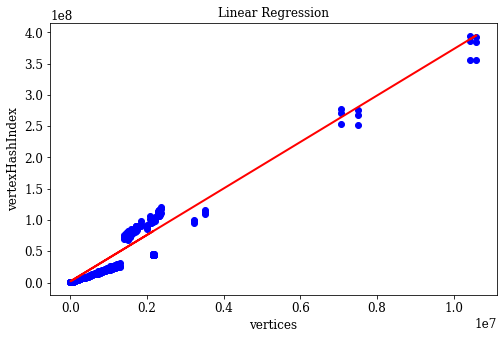

In [97]:
scatter_plot_regression(full_frame, 'vertices', 'vertexHashIndex')

stat=33.490, p=0.000
edges does not follow normal distribution
stat=94.160, p=0.000
vertexHashIndex does not follow normal distribution
Is there a monotonic relationship between 'edges' and 'vertexHashIndex'?
Spearman rank-order correlation coefficient of 0.661 (p = 0.000000)
Is there a linear correlation between 'edges' and 'vertexHashIndex'?
Pearson Coefficient of 0.755 (p = 0.000000)
(144, 1)
(144,)
Linear Regression Coefficient of 5.749


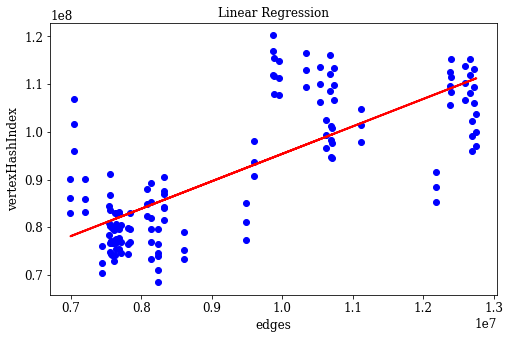

In [52]:
scatter_plot_regression(full_frame, 'edges', 'vertexHashIndex')

# Not usefull stuff

stat=43.599, p=0.000
vertices does not follow normal distribution
stat=189.919, p=0.000
schema-update does not follow normal distribution
Is there a monotonic relationship between 'vertices' and 'schema-update'?
Spearman rank-order correlation coefficient of 0.513 (p = 0.000000)
Is there a linear correlation between 'vertices' and 'schema-update'?
Pearson Coefficient of 0.194 (p = 0.019595)
(144, 1)
(144,)
Linear Regression Coefficient of 0.070


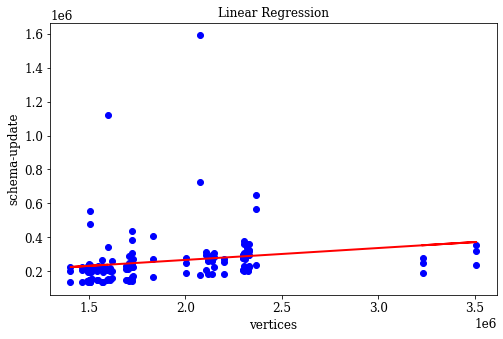

In [53]:
scatter_plot_regression(full_frame, 'vertices', 'schema-update')

stat=33.490, p=0.000
edges does not follow normal distribution
stat=189.919, p=0.000
schema-update does not follow normal distribution
Is there a monotonic relationship between 'edges' and 'schema-update'?
Spearman rank-order correlation coefficient of 0.344 (p = 0.000024)
Is there a linear correlation between 'edges' and 'schema-update'?
Pearson Coefficient of 0.065 (p = 0.435845)
(144, 1)
(144,)
Linear Regression Coefficient of 0.006


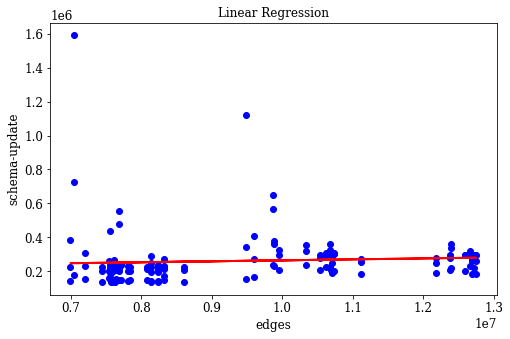

In [54]:
scatter_plot_regression(full_frame, 'edges', 'schema-update')

stat=82.416, p=0.000
instance-changes does not follow normal distribution
stat=189.919, p=0.000
schema-update does not follow normal distribution
Is there a monotonic relationship between 'instance-changes' and 'schema-update'?
Spearman rank-order correlation coefficient of 0.179 (p = 0.031817)
Is there a linear correlation between 'instance-changes' and 'schema-update'?
Pearson Coefficient of 0.391 (p = 0.000001)
(144, 1)
(144,)
Linear Regression Coefficient of 0.284


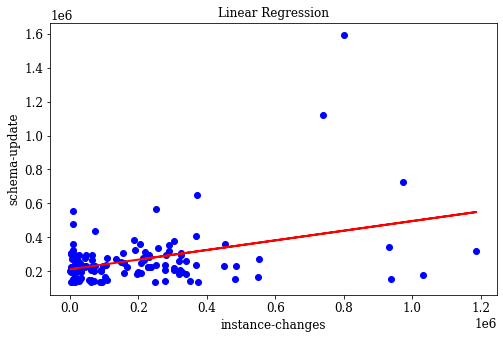

In [55]:
scatter_plot_regression(full_frame, 'instance-changes', 'schema-update')

# OLD STUFF

array([[26.61254239]])

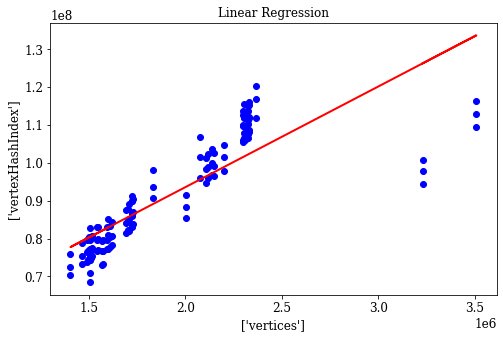

0.6973411937354652

In [13]:
x_values = ['edges'] #'change-ratio'
y_value = ['schema-computation']


x_values = ['vertices'] #'change-ratio'
y_value = ['vertexHashIndex']

#x_values = ['edges'] #'change-ratio'
#y_value = ['vertexHashIndex']

X = full_frame[x_values].values # , 'change-ratio'
y = full_frame[y_value].values

#display(X)

lin = LinearRegression() 
a = [v[0] for v in X]
#b = [v[1] for v in X]
#display(a)
lin.fit(X, y) 
display(lin.coef_)
# Visualising the Linear Regression results 
plt.scatter(a, y, color = 'blue') 
#plt.scatter(b, y, color = 'green') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(x_values) 
plt.ylabel(y_value) 

plt.show() 
lin.score(X, y)


In [14]:
change_frame = pd.DataFrame(columns=['SE-ADD', 'SE-DEL','SE-MOD', 'SE-unchanged', 
                                     'instances', 'stability-ratio', 'change-ratio', 
                                     'update-ratio'])
iterations = 0

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        
        iterations = max(iterations, len(df))
        f2 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
        df2 = pd.read_csv(f2, sep=',')
        df2.head()
        
        df2['Imprint links add-del'] = (df2['Imprint links'] - df2['Imprint links'].shift(1,fill_value=0)).abs()

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 
        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        del df['TotalNumberOfSchemaElementsWritten']

        del df['TotalNumberOfSchemaElementsDeleted']
        df = df.set_index('Iteration')
        
        df.columns = ['SE-ADD', 'SE-DEL','SE-MOD', 'SE-unchanged']
        df['instances'] = df2['Imprint links']
        df['stability-ratio'] = df['SE-unchanged'] / df['instances']
        df['add_del-ratio'] = (df['instances'] - df['SE-MOD'] - df['SE-unchanged'] ) / df['instances']

        
        change_frame.loc[collection+':min'] = df.min()
        change_frame.loc[collection+':max'] = df.max()
        change_frame.loc[collection+':mean'] = df.mean()
        change_frame.loc[collection+':std'] = df.std()
        

change_frame.to_csv(out_dir + '/' + appname + '-stats-changes.csv', sep=',', encoding='utf-8')
display(change_frame)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dataset_data/dyldo_y2019_full_schemex-changes.csv'

In [ ]:
performance_frame = pd.DataFrame(columns=['Load Graph', 'Parse Graph', 'Partition Graph', 'Schema Computation',
       'Updates', 'Total', 'Batch', 'Seepdup'])

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        df = df.set_index('Iteration')
        print(collection)
#         del df['Load Graph']
#         del df['Parse Graph']
#         del df['Partition Graph']
#         del df['Schema Computation']
#         del df['Updates']
#        df.columns = [collection + '-Inc', collection + '-Batch']    
        convert = lambda x: x / 1000 / 60
        df = df.applymap(convert)  
        df['Seepdup'] = df.Batch / df.Total
        display(df)
        performance_frame.loc[collection+':min'] = df.min()
        performance_frame.loc[collection+':max'] = df.max()
        performance_frame.loc[collection+':mean'] = df.mean()
        performance_frame.loc[collection+':std'] = df.std()
display(performance_frame)
performance_frame.to_csv(out_dir + '/' + appname + '-stats-performance.csv', sep=',', encoding='utf-8')

    
    
# df = pd.concat(frames, sort=False)
# df.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#              'AttrColl:Incr', 'AttrColl:Batch',
#              'TypeColl:Incr', 'TypeColl:Batch']
# print(df)
    


In [ ]:
curr_dir = join(data_dir, data_size_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
onlyfiles = sorted(onlyfiles)

edgecounts = {}
tmp = 0
for filename in onlyfiles:
    # first line: number of types in dataset (not unique)
    # second line: number of edges in dataset (not unique)
    f = open(join(curr_dir,filename), 'r')
    content = f.read().split('\n')
    if len(content) > 2:
        edges = int(content[1])
    else:
        edges = int(content[0])
    if 'iteration' in filename:
        iteration = filename.replace('iteration', '')
        iteration = iteration.replace('-', '')
        iteration = iteration.replace('.txt', '')
        iteration = iteration.replace('.gz', '')
        iteration = iteration.replace('.nq', '')
        iteration = iteration.replace('.nt', '')
               
        edgecounts[int(iteration)] = edges
    else:
        edgecounts[tmp] = edges
        tmp = tmp + 1
        
edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
edgeframe = pd.DataFrame.sort_index(edgeframe)
#display(edgeframe)


In [ ]:
size_frame = pd.DataFrame(columns= ['SE links', 'Imprint links', 'Schema Elements (SE)',
       'Schema Relations (SR)', 'summarization-ratio'])

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        del df['SecondaryIndex Read time (ms)']
        del df['SecondaryIndex Write time (ms)']
        del df['SecondaryIndex Del time (ms)']
        #--->
        del df['SecondaryIndex Total time (ms)']
        #<----
        # number of primary vertices
        #del df['SE links']
#         if not size_frame.empty:
#             del df['Imprint links']
        del df['Checksum links']
        #del df['Schema Elements (SE)']
        #del df['Schema Relations (SR)']

        del df['SG Read time (ms)']
        del df['SG Write time (ms)']
        del df['SG Del time (ms)']

        del df['Sec. Index Size (bytes)']
        del df['Index Size (bytes)']
        del df['Graph Size (bytes)']
        #print(df)
        df = df.set_index('Iteration')
        print(df.columns)
        size_frame.loc[collection+':min'] = df.min()
        size_frame.loc[collection+':max'] = df.max()
        size_frame.loc[collection+':mean'] = df.mean()
        size_frame.loc[collection+':std'] = df.std()
        size_frame['summarization-ratio'] = size_frame['Imprint links'] / size_frame['SE links']
        


display(size_frame)
size_frame.to_csv(out_dir + '/' + appname + '-stats-size.csv', sep=',', encoding='utf-8')

In [17]:
correlation_frame = pd.DataFrame()
data_dir = "test"
collections = ['schemex', 'type', 'attribute']#,] #, 'type', 'attribute'] # 'type' 'attribute' 
#collections = ['schemex']

appnames = ["LUBM","BSBM","dyldo_y2019_core"] # "dyldo_y2019_full", #"LUBM", "BSBM"
#appnames = ["BSBM"]#, "LUBM", "BSBM"] # "dyldo_y2019_full", #"LUBM", "BSBM"

suffix = ''
for appname in appnames:
    for collection in collections:
        with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
            
            df = pd.read_csv(f, sep=',')
            display(df.head())
            temp_frame = pd.DataFrame()
            #temp_frame['Iteration'] = df['Iteration']
            #df = df.set_index('Iteration')

            #temp_frame = temp_frame.set_index('Iteration')

            temp_frame['schema-computation'] = df['Schema Computation']
            temp_frame['performance'] = df.Total
            #temp_frame['speed-up'] = df.Batch / df.Total
            temp_frame['updates'] = df['Updates']
            f2 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r')
            df2 = pd.read_csv(f2, sep=',')
            #df2 = df2.set_index('Iteration')

            display(df2)


            f3 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
            df3 = pd.read_csv(f3, sep=',')
            df3 = df3.set_index('Iteration')
            temp_frame['size'] = df3['Imprint links']
            df['instances'] = df3['Imprint links']
            df['SE-unchanged'] = df2['InstanceNotChanged (PE_mod)']

            #display(df)
            #display(degree_frame['max_degree'])
            temp_frame['max-degree'] = degree_frame['max_degree']
            temp_frame['avg-degree'] = degree_frame['avg_degree']

            temp_frame['change-ratio'] = ((df3['Imprint links'] - df2['InstanceNotChanged (PE_mod)']) / df3['Imprint links'])
            temp_frame['update-ratio'] = (df2['NewlyObservedSchema (SE_new)'] + df2['DeletedSchemaStructures (SE_del)']) / df3['Schema Elements (SE)']
            temp_frame['total-changes'] = (df3['Imprint links'] - df2['InstanceNotChanged (PE_mod)'])
            temp_frame['total-updates'] = (df2['NewlyObservedSchema (SE_new)'] + df2['DeletedSchemaStructures (SE_del)'])
            temp_frame['summary-size'] = df3['Schema Elements (SE)']
#             temp_frame['change-ratio'] = 1 - (df2['InstanceNotChanged (PE_mod)'] / df3['Imprint links'].shift(1))
            temp_frame['summarization-ratio'] =  df3['Imprint links']/ df3['SE links'].shift(1)
#             temp_frame['summary-mod-ratio'] = (df2['TotalNumberOfSchemaElementsWritten'] + df2['TotalNumberOfSchemaElementsDeleted']) /(1 * df3['Schema Elements (SE)'].shift(1)
#)# 
            # test new summary graphs
            temp_frame['summary-adds'] = df2['NewlyObservedSchema (SE_new)']
            
            temp_frame['add-vs-updates'] = df2['NewlyObservedSchema (SE_new)'] / df2['TotalNumberOfSchemaElementsWritten']
            temp_frame['del-vs-update'] = df2['DeletedSchemaStructures (SE_del)'] / df2['TotalNumberOfSchemaElementsDeleted']
            
            #display(temp_frame)
            if correlation_frame.empty:
                correlation_frame = temp_frame.iloc[1:]
            else:
                correlation_frame = correlation_frame.append(temp_frame.iloc[1:])

                

correlation_frame['combined'] = correlation_frame['size'] * correlation_frame['summarization-ratio']            

#display(degree_frame)
#correlation_frame['ssss'] = degree_frame['avg_degree']
correlation_frame['add-time'] = correlation_frame['summary-adds'] / correlation_frame['updates']            

display(correlation_frame)

print(correlation_frame['add-time'].mean())

FileNotFoundError: [Errno 2] No such file or directory: 'test/LUBM_schemex-performance.csv'

In [16]:
correlation_frame

NameError: name 'correlation_frame' is not defined

In [ ]:
print('ms per addition')
print(correlation_frame['add-time'].mean())
print(correlation_frame['add-time'].std())

In [ ]:
x_values = ['size'] #'change-ratio'
y_value = ['schema-computation']
X = correlation_frame[x_values].values # , 'change-ratio'
y = correlation_frame[y_value].values

#display(X)

lin = LinearRegression() 
a = [v[0] for v in X]
#b = [v[1] for v in X]
#display(a)
lin.fit(X, y) 
display(lin.coef_)
# Visualising the Linear Regression results 
plt.scatter(a, y, color = 'blue') 
#plt.scatter(b, y, color = 'green') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(x_values) 
plt.ylabel(y_value) 

plt.show() 
lin.score(X, y)

In [ ]:
# Total berechnung hängt vom Datensatz ab, nicht nur von der Größe (param = 1)
# Change ratio nicht unbedingt


In [ ]:
X = correlation_frame.iloc[:, 4:5].values 
y = correlation_frame.iloc[:, 0].values 
lin = LinearRegression() 

lin.fit(X, y) 
# Visualising the Linear Regression results 
plt.scatter(X, y, color = 'blue') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(correlation_frame.columns[4]) 
plt.ylabel(correlation_frame.columns[0]) 

plt.show() 

In [ ]:
X = correlation_frame.iloc[:, 3:4].values 
y = correlation_frame.iloc[:, 0].values 
lin = LinearRegression() 

lin.fit(X, y) 
# Visualising the Linear Regression results 
plt.scatter(X, y, color = 'blue') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel('Combined-factor ratio') 
plt.ylabel('Speed-up') 


plt.show() 